# MrVI Quick Start Tutorial

MrVI (Multi-resolution Variational Inference) is a model for analyzing multi-sample single-cell RNA-seq data. This tutorial will guide you through the main features of MrVI.
MrVI is particularly suited for single-cell RNA sequencing datasets with comparable observations across many samples. By comparable, we mean observations derived from the same tissue or from the same cell line. This ensures that MrVI can provide accurate, single-cell-resolution estimates.


In [ ]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

INFO     scvi-colab: Installing scvi-tools.                                                                        
INFO     scvi-colab: Install successful. Testing import.                                                           


/usr/local/lib/python3.12/dist-packages/pyro/ops/stats.py:527: SyntaxWarning: invalid escape sequence '\g'
  we have :math:`ES^{*}(P,Q) \ge ES^{*}(Q,Q)` with equality holding if and only if :math:`P=Q`, i.e.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import scipy.io
import scipy.sparse
import anndata as ad

load dataset by importing matrix, cell, gene data

In [ ]:

# 1. Load the count matrix (sparse format)
X = scipy.io.mmread("/content/drive/My Drive/Fig2_jurkat_screen/matrix.mtx").tocsr()  # or .tocsc(), depending on access pattern

# 2. Load observation (cell) and variable (gene) metadata
obs = pd.read_csv("/content/drive/My Drive/Fig2_jurkat_screen/obs.csv", index_col=0)
var = pd.read_csv("/content/drive/My Drive/Fig2_jurkat_screen/var.csv", index_col=0)

# 3. Check that dimensions match
assert X.shape[0] == obs.shape[0], "Number of rows in matrix != number of cells in obs"
assert X.shape[1] == var.shape[0], "Number of cols in matrix != number of genes in var"

# 4. Create AnnData object
adata = ad.AnnData(X=X, obs=obs, var=var)


In [ ]:
!pip install scvi-tools@git+https://github.com/scverse/scvi-tools

  Cloning https://github.com/scverse/scvi-tools to /tmp/pip-install-qx1xqznm/scvi-tools_de80814ca1f542f0ba9ecb6cb3157db8
  Running command git clone --filter=blob:none --quiet https://github.com/scverse/scvi-tools /tmp/pip-install-qx1xqznm/scvi-tools_de80814ca1f542f0ba9ecb6cb3157db8
  Resolved https://github.com/scverse/scvi-tools to commit 3e275ffe00e85b73be5295864df0e1f99b94411f
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import scvi
from scvi.external import MRVI

install additionaly packges

In [ ]:
!pip install scanpy
!pip install anndata

In [ ]:
!pip install pymde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 186.4/186.4 kB 6.5 MB/s eta 0:00:00


In [ ]:
import pymde

In [ ]:
import os
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import anndata as ad

scvi.settings.seed = 0  # optional: ensures reproducibility
print("Last run with scvi-tools version:", scvi.__version__)
save_dir = tempfile.TemporaryDirectory()

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0


Last run with scvi-tools version: 1.4.1


# Preprocessing and model fitting

In [ ]:
adata
adata.obs['oligo'] = adata.obs['oligo'].str.replace(r'Media_\d+', 'Media', regex=True)
adata.obs['oligo'] = adata.obs['oligo'].str.replace(r'DMSO_\d+', 'DMSO', regex=True)


In [ ]:
#new_adata = ad.AnnData(
    # X=transposed_data,
     #obs=adata.var.copy(),  # Copy var metadata to obs
     #var=adata.obs.copy()   # Copy obs metadata to var
#)
#del adata, transposed_data

filter for genes present in >.5% of cells

In [ ]:
adata
adata.var
sc.pp.filter_genes(adata, min_cells=int(0.005*adata.shape[0]))

In [ ]:
# rename varnames to be id
#adata.var['gene_short_name'] = adata.var['gene_short_name'].astype(str)
adata.var_names = adata.var['id']
adata.var_names_make_unique()


In [ ]:
len(list(set(adata.var_names)))

7351

In [ ]:
adata.layers["counts"] = adata.X.copy()
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,
                            flavor='seurat',
                            n_top_genes=500,
                            inplace=True,
                            subset=False)

adata.X = adata.layers["counts"].copy()


scanpy determined HVG genes plus probe genes

In [ ]:
hvg_genes = adata.var_names[adata.var['highly_variable']].tolist()
probe_genes=["ENSG00000010610.9","ENSG00000081237.18","ENSG00000109471.4","ENSG00000110848.8","ENSG00000134460.15","ENSG00000153563.15","ENSG00000160654.9" ,"ENSG00000188389.10","ENSG00000277734.7" ]
all_target_genes = set(hvg_genes) | set(probe_genes)
adata = adata[:, adata.var_names.isin(all_target_genes)].copy()
adata


AnnData object with n_obs × n_vars = 50774 × 506
    obs: 'cell', 'sample', 'n.umi', 'P7', 'P5', 'RT', 'Lig', 'oligo', 'hash_umis', 'total_hash_umis_per_cell', 'top_to_second_best_ratio', 'treatment', 'dose', 'log10.umi', 'percent_mito', 'num_genes_expressed', 'Size_Factor', 'Cluster'
    var: 'id', 'gene_short_name', 'num_cells_expressed', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [ ]:
adata

AnnData object with n_obs × n_vars = 50774 × 506
    obs: 'cell', 'sample', 'n.umi', 'P7', 'P5', 'RT', 'Lig', 'oligo', 'hash_umis', 'total_hash_umis_per_cell', 'top_to_second_best_ratio', 'treatment', 'dose', 'log10.umi', 'percent_mito', 'num_genes_expressed', 'Size_Factor', 'Cluster'
    var: 'id', 'gene_short_name', 'num_cells_expressed', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'counts'

In [ ]:
adata.write_h5ad(
    '/content/drive/My Drive/adata/jurkat/jurkat_2.h5ad'
)


In [ ]:
adata = ad.read_h5ad(
    "/content/drive/My Drive/adata/jurkat/jurkat_2.h5ad"
)

Before training, we need to specify which covariates in `obs` should be used as target (`sample_key`) and nuisance variables (`batch_key`).
In this tutorial, we will use donor IDs (`patient_id`) as the target variable, and leave the batch variable empty since the data is already subsetted to the Newcastle cohort (denoted in `Site`).

Otherwise, we will focus on the following `obs` keys for the analysis:
- `initial_clustering`: coarse cell-type annotations from the original study.
- `Status`: whether the donor had COVID-19 or was healthy.
- `Days_from_onset`: how many days it had been since the onset of symptoms before the sample was taken.

In [ ]:
# batch_key="Site"  # nuisance variable identifier
MRVI.setup_anndata(adata, sample_key="oligo", batch_key="sample")

/tmp/ipython-input-237580595.py:2: UserWarning: MRVI model is being setup with JAX backend
  MRVI.setup_anndata(adata, sample_key="oligo", batch_key="sample")


In [ ]:
model = MRVI(adata)
model.train(max_epochs=150)

INFO     Jax module moved to TFRT_CPU_0.Note: Pytorch lightning will show GPU is not being used for the Trainer.   


/tmp/ipython-input-3665446190.py:2: UserWarning: Running mrVI with Jax version larger 0.4.35 can cause performance issues
  model.train(max_epochs=150)
/usr/local/lib/python3.12/dist-packages/scvi/dataloaders/_data_splitting.py:258: UserWarning: 1 cells moved from training set to validation set. if you want to avoid it please use train_size parameter during train.
  self.n_train, self.n_val = validate_data_split(
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Training:   0%|          | 0/150 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=150` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.


Once trained, we can plot the ELBO of the model to check if the model has converged.

In [ ]:
model.save("/content/drive/My Drive/adata/jurkat3", overwrite=False)

In [ ]:
del(cell_reps)

load model

In [ ]:
model = MRVI.load("/content/drive/My Drive/adata/jurkat3", adata=adata)

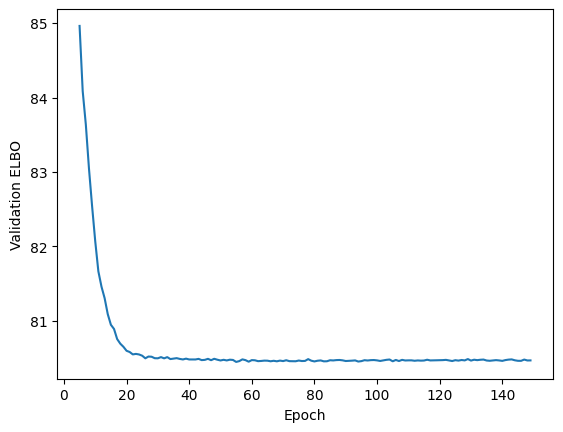

In [ ]:
plt.plot(model.history["elbo_validation"].iloc[5:])
plt.xlabel("Epoch")
plt.ylabel("Validation ELBO")
plt.show()

# Visualize cell embeddings and sample distances

The latent representations of the cells can also be accessed and visualized using the `get_latent_representation` method.
MrVI learns two latent representations: `u` and `z`. `u` is designed to capture broad cell states invariant to sample and nuisance covariates, while `z` augments `u` with sample-specific effects but remains corrected for nuisance covariate effects.

Here, we visualize the `u` latent space in 2D using minimum-distortion embeddings~(MDE).

In [ ]:
print("Last run with scvi-tools version:", scvi.__version__)

Last run with scvi-tools version: 1.4.0


In [ ]:
u = model.get_latent_representation()

100%|██████████| 397/397 [00:10<00:00, 36.30it/s] 


In [ ]:
#adata.obsm["u"] = u
import pymde
u_mde = pymde.preserve_neighbors(u, embedding_dim=2).embed(verbose=False)
adata.obsm["u_mde"] = u_mde.detach().cpu().numpy()




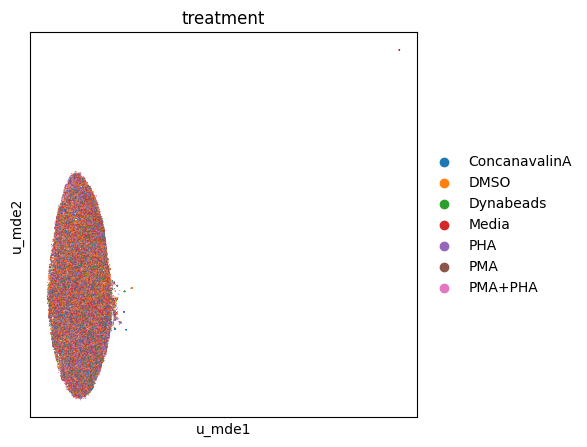

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sc.settings.figdir = '/content/drive/My Drive/adata/jurkat3/'
sc.pl.embedding(
    adata,
    basis="u_mde",
    color=["treatment"],
    ncols=1,
    ax=ax,
    save="u_space_plot.pdf"
)


In [ ]:
z = model.get_latent_representation(give_z=True)

import pymde
u_mde = pymde.preserve_neighbors(z, embedding_dim=2).embed(verbose=False)
adata.obsm["z_mde"] = u_mde.detach().cpu().numpy()



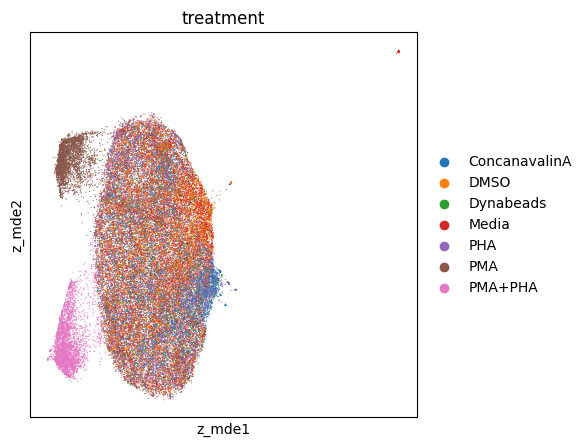

In [ ]:
# Plot mde using 'z' as the embedding
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.embedding(
    adata,
    basis="z_mde",
    color=["treatment"],
    ncols=1,
    ax=ax,
    save="z_space_plot.pdf"
)

# Cell distance

In [ ]:
# Compute local sample representations
cell_reps = model.get_local_sample_representation(
    adata,
    batch_size=512      # helps on large datasets
)

100%|██████████| 100/100 [00:24<00:00,  4.08it/s]


In [ ]:
np.save("/content/drive/My Drive/adata/jurkat/cell_reps.npy", cell_reps)

In [ ]:
del cell_reps

In [ ]:

dists = model.get_local_sample_distances(
    keep_cell=False, groupby="oligo", batch_size=256)

100%|██████████| 199/199 [01:23<00:00,  2.39it/s]


In [ ]:
type(dists)

xarray.core.dataset.Dataset

In [ ]:
# save dists
dists.to_netcdf("/content/drive/My Drive/adata/jurkat/cell_dists_f.png")

In [ ]:
import xarray as xr

cell_dists = xr.load_dataset("/content/drive/My Drive/adata/simunovic_cell_dists.png")

In [ ]:
dists

<xarray.Dataset> Size: 21kB
Dimensions:     (sample_x: 17, sample_y: 17, oligo_name: 17)
Coordinates:
  * sample_x    (sample_x) object 136B 'ConcanavalinA_1' ... 'PMA_4'
  * sample_y    (sample_y) object 136B 'ConcanavalinA_1' ... 'PMA_4'
  * oligo_name  (oligo_name) <U15 1kB 'Media' 'DMSO' ... 'Dynabeads_4'
Data variables:
    oligo       (oligo_name, sample_x, sample_y) float32 20kB 0.0 ... 0.0

Sample distances can be computed using the `get_local_sample_distances` method, which characterizes sample relationships for any cell in the dataset.
This method can return cell-specific distances (`keep_cell=True`), as well as averaged distances within cell subpopulations, characterized by the `groupby` argument.
Specifying `keep_cell=False` will ensure that cell-specific distances are not returned, which can reduce the memory footprint of the returned object in the case where many samples are present.

In [ ]:
drug_dist_df = pd.DataFrame(
        dists['oligo'].mean(axis=0),
        columns = dists['sample_x'].values,
        index = dists['sample_y'].values
)
drug_dist_df

,ConcanavalinA_1,ConcanavalinA_2,ConcanavalinA_4,DMSO,Dynabeads_1,Dynabeads_2,Dynabeads_4,Media,PHA_1,PHA_2,PHA_4,PMA+PHA_1,PMA+PHA_2,PMA+PHA_4,PMA_1,PMA_2,PMA_4
ConcanavalinA_1,0.000000,0.035641,0.093941,0.108799,0.086379,0.026940,0.133469,0.141412,0.092248,0.093918,0.094153,0.225774,0.225594,0.224183,0.201973,0.203125,0.199851
ConcanavalinA_2,0.035641,0.000000,0.062915,0.112427,0.079349,0.011587,0.104310,0.139442,0.062135,0.063667,0.064191,0.201183,0.200968,0.199165,0.175594,0.177579,0.174406
ConcanavalinA_4,0.093941,0.062915,0.000000,0.109653,0.069340,0.074380,0.067708,0.121724,0.005370,0.005790,0.006551,0.148160,0.147909,0.145542,0.140655,0.144575,0.142490
DMSO,0.108799,0.112427,0.109653,0.000000,0.040563,0.116753,0.135152,0.036162,0.107123,0.108800,0.107858,0.204947,0.204845,0.203512,0.188501,0.189009,0.187279
Dynabeads_1,0.086379,0.079349,0.069340,0.040563,0.000000,0.086253,0.101960,0.060716,0.066898,0.068673,0.067786,0.180327,0.180174,0.178481,0.164291,0.165852,0.163871
Dynabeads_2,0.026940,0.011587,0.074380,0.116753,0.086253,0.000000,0.114102,0.145561,0.073499,0.075005,0.075516,0.210728,0.210519,0.208818,0.184307,0.186039,0.182758
Dynabeads_4,0.133469,0.104310,0.067708,0.135152,0.101960,0.114102,0.000000,0.137905,0.072414,0.072954,0.073260,0.166268,0.166009,0.162458,0.074199,0.077638,0.075259
Media,0.141412,0.139442,0.121724,0.036162,0.060716,0.145561,0.137905,0.000000,0.119688,0.121024,0.119936,0.196034,0.195952,0.194506,0.181420,0.181977,0.180992
PHA_1,0.092248,0.062135,0.005370,0.107123,0.066898,0.073499,0.072414,0.119688,0.000000,0.002389,0.002704,0.147708,0.147462,0.145222,0.145220,0.149114,0.147060
PHA_2,0.093918,0.063667,0.005790,0.108800,0.068673,0.075005,0.072954,0.121024,0.002389,0.000000,0.001299,0.145913,0.145665,0.143428,0.145548,0.149544,0.147531


In [ ]:
# save sample-sample dist matrix
drug_dist_df.to_csv('/content/drive/My Drive/adata/jurkat/dist_df_f_2.csv')

In [ ]:
drug_dist_df = pd.read_csv('/content/drive/My Drive/adata/jurkat/dist_df_f_2.csv',
    index_col=0)

The following cell provides useful utility functions to perform hierarchical clustering based on sample distances, as well as to extract sample metadata of interest to visualize the distance matrices

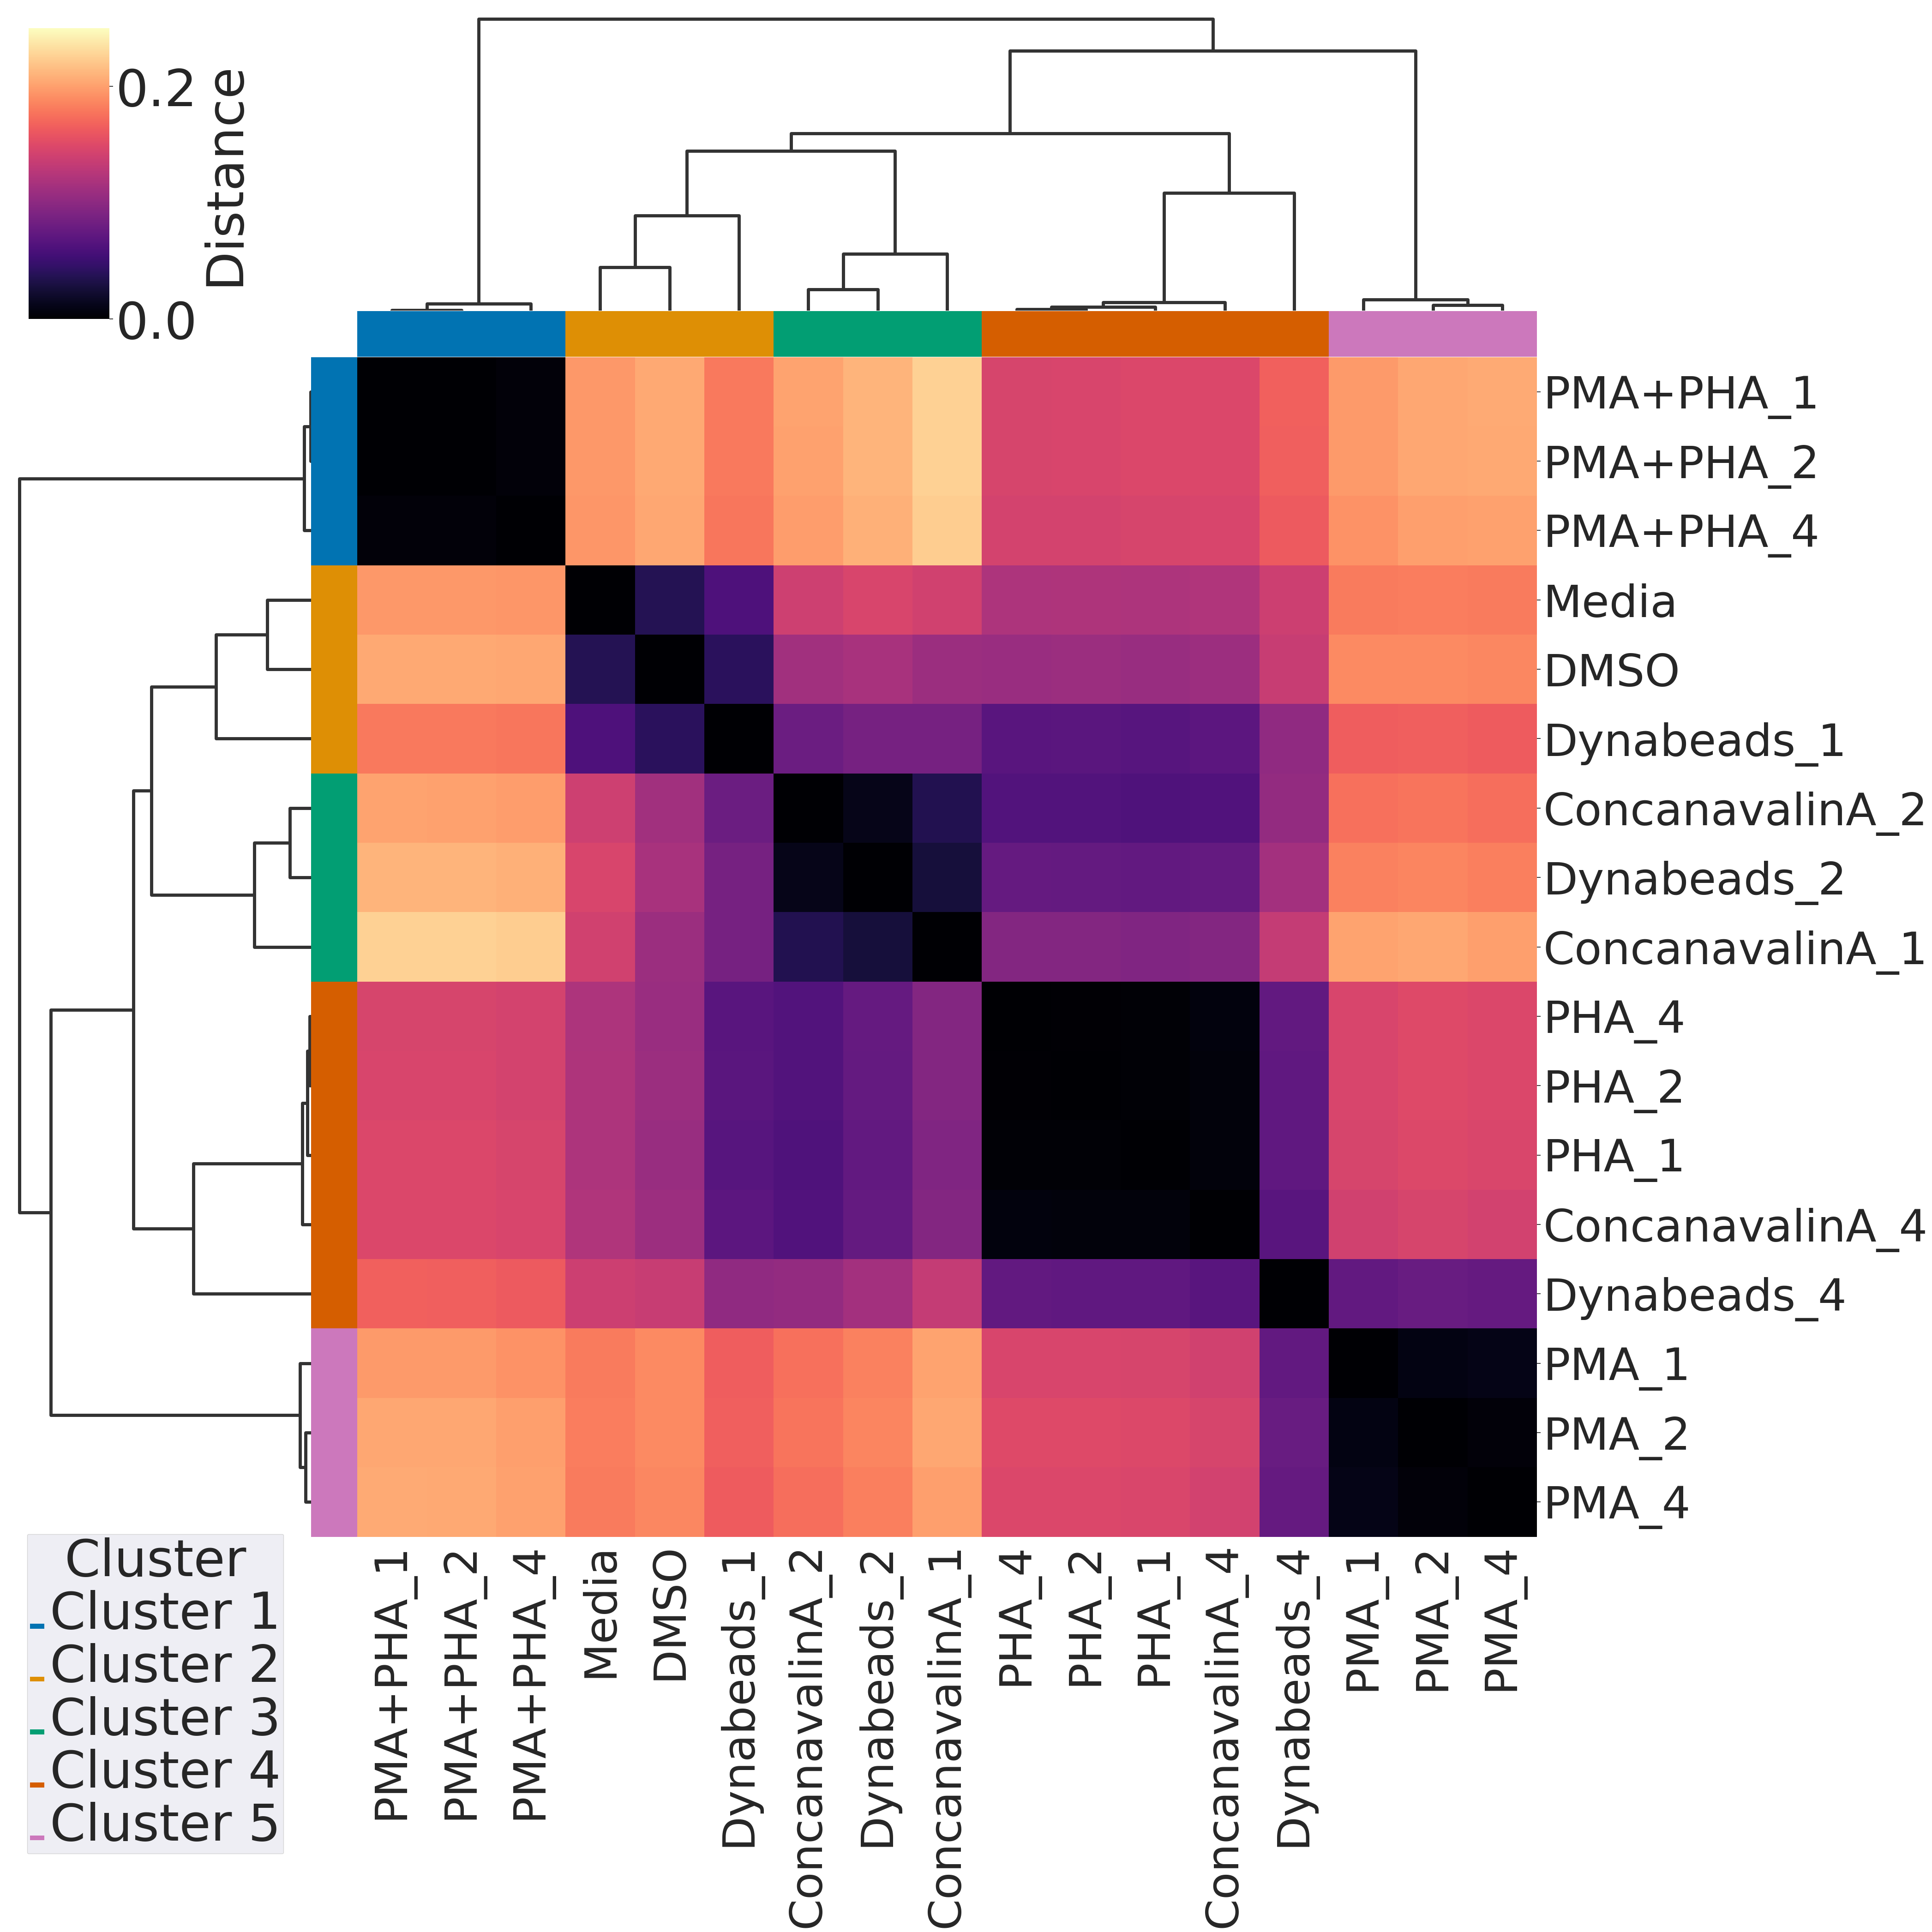

In [ ]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from matplotlib.pyplot import gcf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cluster_method = 'complete'
plt.rcParams['pdf.fonttype'] = 42
dist_matrix = distance.pdist(drug_dist_df)

# Perform hierarchical clustering to get the initial linkage
initial_row_linkage = hierarchy.linkage(dist_matrix, method=cluster_method)

# Apply optimal leaf ordering to get an improved linkage
row_linkage = hierarchy.optimal_leaf_ordering(initial_row_linkage, dist_matrix)
col_linkage = row_linkage # Symmetric clustering

# Get cluster labels based on the optimally ordered linkage
row_col_labels = fcluster(row_linkage, t=.25, criterion='distance')
lut = dict(zip(np.unique(row_col_labels), sns.color_palette("colorblind", n_colors=len(np.unique(row_col_labels)))))
row_col = pd.Series(row_col_labels, index=drug_dist_df.index).map(lut)

sns.set(font_scale=1)


g = sns.clustermap(drug_dist_df,
                   row_linkage=row_linkage,
                   col_linkage=col_linkage,
                   method=cluster_method,
                   row_colors=[row_col],
                   col_colors=[row_col],
                   annot=False,
                   figsize=(35, 35),
                   cmap='magma',
                   yticklabels=True, xticklabels=True,
                   vmin=0, vmax=.25)

# Update legend based on the reordered labels
for label_idx in np.unique(row_col_labels):
    g.ax_col_dendrogram.bar(0, 0, color=lut[label_idx], label=f'Cluster {label_idx}', linewidth=0)

l1 = g.ax_col_dendrogram.legend(
    title='Cluster',
    loc="upper right",
    bbox_to_anchor=(0.18, 0.05),
    bbox_transform=gcf().transFigure,
    ncol=1,
    title_fontsize=80,
    markerscale=10.0
)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=70)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=360, fontsize=70)
g.ax_cbar.tick_params(labelsize=80)
g.ax_cbar.set_ylabel('Distance', fontsize=80)

for text in l1.get_texts():
    text.set_fontsize(80)

for line in g.ax_row_dendrogram.collections:
    line.set_linewidth(5)
for line in g.ax_col_dendrogram.collections:
    line.set_linewidth(5)


#g.savefig('/content/drive/My Drive/adata/jurkat/plots/cluster_heatmap_2.pdf', bbox_inches="tight")
plt.show()

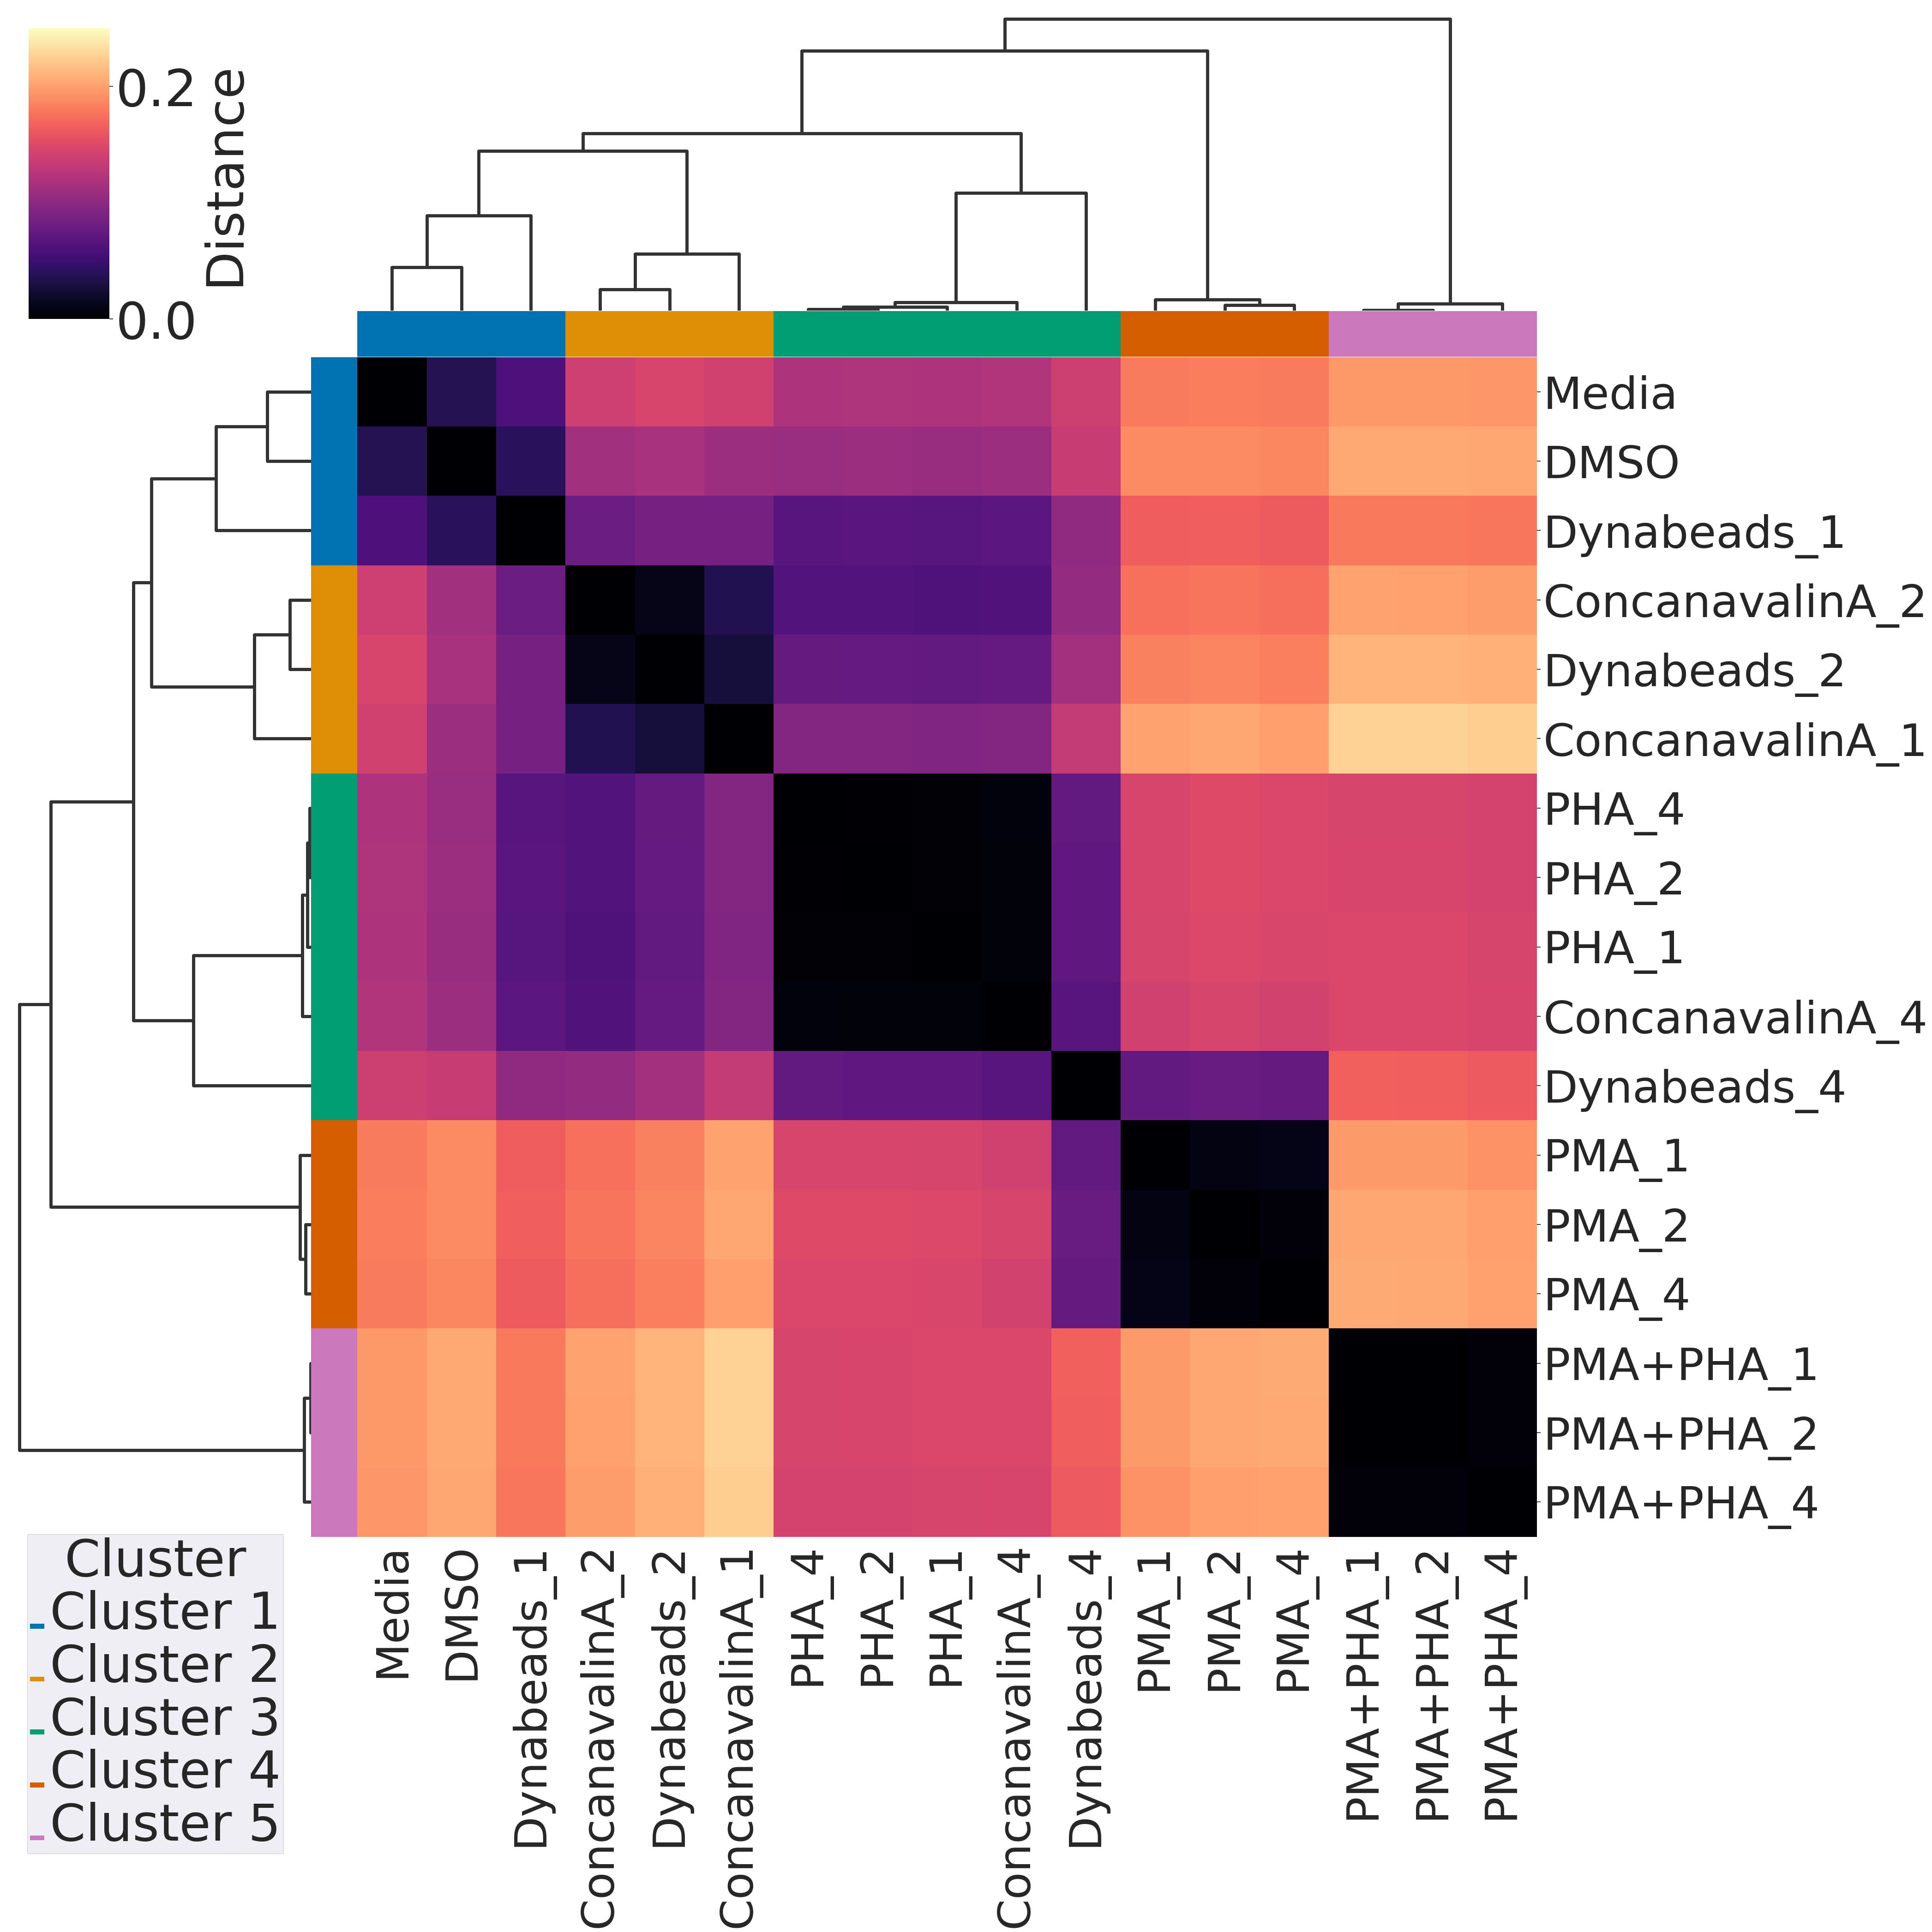

In [ ]:
from scipy.spatial import distance
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster
from matplotlib.pyplot import gcf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

cluster_method = 'complete'
plt.rcParams['pdf.fonttype'] = 42
dist_matrix = distance.pdist(drug_dist_df)

initial_row_linkage = hierarchy.linkage(dist_matrix, method=cluster_method)
row_linkage = hierarchy.optimal_leaf_ordering(initial_row_linkage, dist_matrix)
col_linkage = row_linkage

idx_0 = row_linkage[-1, 0]
idx_1 = row_linkage[-1, 1]

row_linkage[-1, 0] = idx_1
row_linkage[-1, 1] = idx_0

col_linkage[-1, 0] = idx_1
col_linkage[-1, 1] = idx_0


row_col_labels = hierarchy.fcluster(row_linkage, t=.25, criterion='distance')
lut = dict(zip(np.unique(row_col_labels), sns.color_palette("colorblind", n_colors=len(np.unique(row_col_labels)))))
row_col = pd.Series(row_col_labels, index=drug_dist_df.index).map(lut)

sns.set(font_scale=1)

g = sns.clustermap(drug_dist_df,
                   row_linkage=row_linkage,
                   col_linkage=col_linkage,
                   method=cluster_method,
                   row_colors=[row_col],
                   col_colors=[row_col],
                   annot=False,
                   figsize=(35, 35),
                   cmap='magma',
                   yticklabels=True, xticklabels=True,
                   vmin=0, vmax=.25)

for label_idx in np.unique(row_col_labels):
    g.ax_col_dendrogram.bar(0, 0, color=lut[label_idx], label=f'Cluster {label_idx}', linewidth=0)

l1 = g.ax_col_dendrogram.legend(
    title='Cluster',
    loc="upper right",
    bbox_to_anchor=(0.18, 0.05),
    bbox_transform=gcf().transFigure,
    ncol=1,
    title_fontsize=80,
    markerscale=10.0
)

g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, fontsize=70)
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=360, fontsize=70)
g.ax_cbar.tick_params(labelsize=80)
g.ax_cbar.set_ylabel('Distance', fontsize=80)

for text in l1.get_texts():
    text.set_fontsize(80)

for line in g.ax_row_dendrogram.collections:
    line.set_linewidth(5)
for line in g.ax_col_dendrogram.collections:
    line.set_linewidth(5)

In [ ]:
g.savefig('/content/drive/My Drive/adata/jurkat/plots/cluster_heatmap_2.pdf', bbox_inches="tight")
plt.show()